In [42]:
import random
import torch


In [43]:
import hashlib
import os
import requests
import re
import collections
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

DATA_HUB['time_machine'] = (DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname
def read_time_machine():
    with open(download('time_machine'),'r') as fp:
        lines = fp.readlines()
    return [re.sub('[^A-Za-z]+',' ',line).strip().lower() for line in lines]
def tokenize(lines,token='word'):
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误')
class Vocab:
    def __init__(self,tokens=None,min_freq=0,reserved_token=None):
        if tokens is None:
            tokens = []
        if reserved_token is None:
            reserved_token = []
        counter = self.count_corpus(tokens)
        self.token_freqs = sorted(counter.items(),key=lambda x :x[1],reverse=True)
        
        self.unk , uniq_token = 0,['<unk>'] + reserved_token

        uniq_token+=[
            token for token,freq in self.token_freqs
            if freq >= min_freq and token not in uniq_token
        ] 
        self.idx_to_token ,self.token_to_idx = [],dict()
        for token in uniq_token:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1
    def count_corpus(self,tokens):
        if len(tokens)==0 or isinstance(tokens[0],list):
            tokens = [token for line in tokens
                      for token in line]
        return collections.Counter(tokens)
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self,indices):
        if not isinstance(indices,(list,tuple)):
            return self.token_to_idx[indices]
        return [self.token_to_idx[index] for index in indices]
    def to_tokens(self,indices):
        if not isinstance(indices,(list,tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    

tokens = tokenize(read_time_machine())
corpus = [token for line in tokens for token in line]
vocab = Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

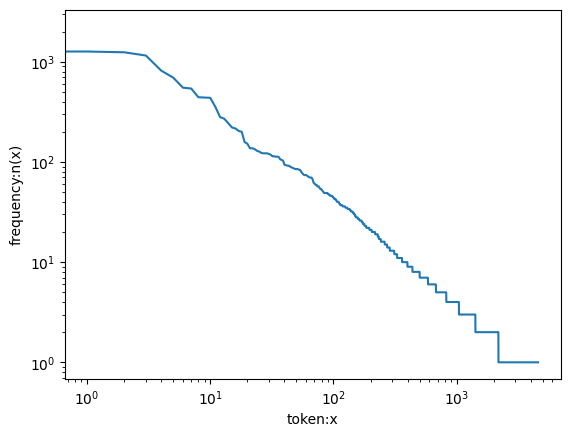

In [44]:
freqs = [frep for _,frep in vocab.token_freqs]
from matplotlib import pyplot as plt
plt.plot(freqs)
plt.xlabel('token:x')
plt.ylabel('frequency:n(x)')
plt.xscale('log')
plt.yscale('log')

In [45]:
bigram_tokens = [pair for pair in zip(corpus[:-1],corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [46]:
trigram_tokens = [
    triple for triple in zip(corpus[:-2],corpus[1:-1],corpus[2:])
]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

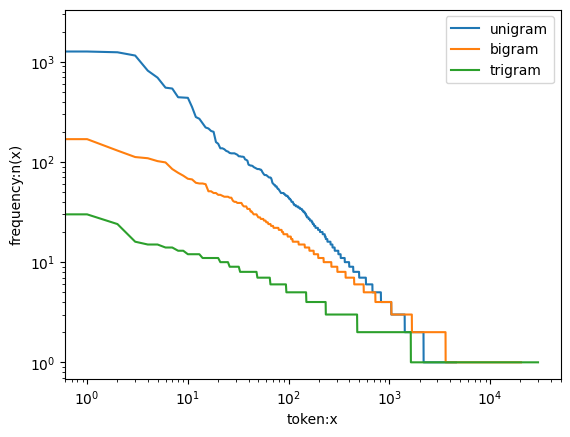

In [47]:
bigram_freqs = [freq for _,freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for _,freq in trigram_vocab.token_freqs]

plt.plot(freqs, label='unigram')
plt.plot(bigram_freqs, label='bigram')
plt.plot(trigram_freqs, label='trigram')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('token:x')
plt.ylabel('frequency:n(x)')
plt.legend()

In [48]:
def seq_data_iter_random(corpus,bathch_size,num_step):
    
    corpus = corpus[random.randint(0,num_step-1):]
    num_subseqs = (len(corpus) - 1) // num_step
    # 保留label
    initial_indices = list(range(0,num_subseqs * num_step,num_step))
    random.shuffle(initial_indices)
    
    def data(pos):
        return corpus[pos :pos+num_step]
    # def label(pos):
    #     return corpus[pos+num_step]
    num_batches = num_subseqs // bathch_size
    for i in range(0,bathch_size * num_batches,bathch_size):
        initial_indices_per_batch = initial_indices[i:i+bathch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X),torch.tensor(Y)
x = seq_data_iter_random(vocab[corpus],2,4)

feature,label = next(x)
feature,label,label[:,-1]

(tensor([[ 12, 192, 129,  42],
         [  1, 655,   4,   1]]),
 tensor([[ 192,  129,   42,  144],
         [ 655,    4,    1, 1185]]),
 tensor([ 144, 1185]))

In [49]:
my_seq = list(range(35))
for x,y in seq_data_iter_random(my_seq,bathch_size=2,num_step=5):
    print(f"x:{x}\n",f"y:{y}\n")

x:tensor([[ 2,  3,  4,  5,  6],
        [12, 13, 14, 15, 16]])
 y:tensor([[ 3,  4,  5,  6,  7],
        [13, 14, 15, 16, 17]])

x:tensor([[22, 23, 24, 25, 26],
        [27, 28, 29, 30, 31]])
 y:tensor([[23, 24, 25, 26, 27],
        [28, 29, 30, 31, 32]])

x:tensor([[ 7,  8,  9, 10, 11],
        [17, 18, 19, 20, 21]])
 y:tensor([[ 8,  9, 10, 11, 12],
        [18, 19, 20, 21, 22]])



In [50]:
def seq_data_iter_sequential(corpus,bath_size,num_step):
    offset = random.randint(0,num_step)
    num_tokens = ((len(corpus) - offset - 1)//bath_size) * bath_size

    Xs = torch.tensor(corpus[offset:offset + num_tokens])
    Ys = torch.tensor([corpus[offset + 1: offset + 1 + num_tokens]])

    Xs,Ys = Xs.reshape(bath_size ,-1),Ys.reshape(bath_size,-1)
    num_batches = Xs.shape[-1] // num_step

    for i in range(0,num_step * num_batches,num_step):
        x = Xs[:,i:i+num_step]
        y = Ys[:,i:i+num_step]
        yield x,y


In [51]:
for x, y in seq_data_iter_sequential(my_seq,bath_size=2,num_step=4):
    print(f"x:{x}\n",f"y:{y}\n",sep='')

x:tensor([[ 4,  5,  6,  7],
        [19, 20, 21, 22]])
y:tensor([[ 5,  6,  7,  8],
        [20, 21, 22, 23]])

x:tensor([[ 8,  9, 10, 11],
        [23, 24, 25, 26]])
y:tensor([[ 9, 10, 11, 12],
        [24, 25, 26, 27]])

x:tensor([[12, 13, 14, 15],
        [27, 28, 29, 30]])
y:tensor([[13, 14, 15, 16],
        [28, 29, 30, 31]])



In [52]:
def load_corpus_time_machine(max_tokens=-1):
    lines = read_time_machine()
    tokens = tokenize(lines,'char')
    vocab = Vocab(tokens)
    corpus = [
        vocab[token] for line in tokens
                    for token in line 
    ]
    if max_tokens >0:
        corpus = corpus[:max_tokens]
    
    return corpus,vocab


In [53]:
class SeqDataloader:
    def __init__(self,batch_size,num_step,use_random_split,max_token):
        if use_random_split:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        
        self.corpus , self.vocab = load_corpus_time_machine(max_tokens=max_token)
        self.batch_size,self.num_step = batch_size,num_step

    
    def __iter__(self):
        return self.data_iter_fn(self.corpus,self.batch_size,self.num_step)

In [54]:
def load_data_time_machine(batch_size,
                           num_step,
                           use_random_split=False,
                           max_token=1000):
    data_iter = SeqDataloader(
        batch_size=batch_size,
        num_step=num_step,
        use_random_split=use_random_split,
        max_token=max_token
    )
    return data_iter,data_iter.vocab